# Определение возраста покупателей

## Исследовательский анализ данных

In [2]:
import pandas as pd 
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dense,MaxPooling2D,AveragePooling2D,AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow import keras 
from keras.datasets import fashion_mnist 
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Found 7591 validated image filenames.


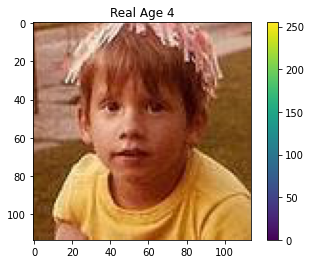

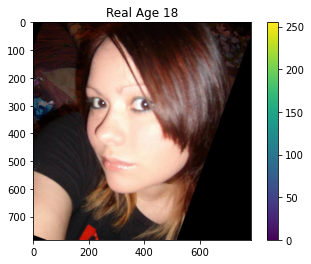

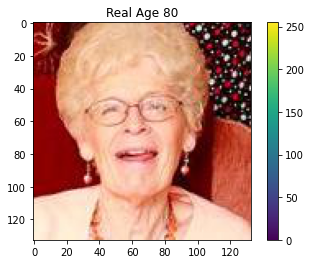

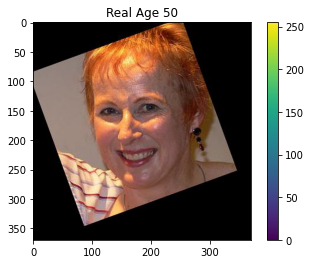

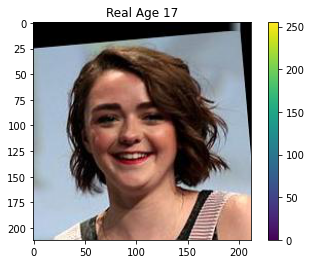

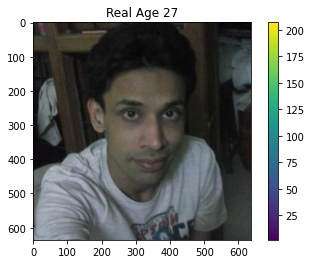

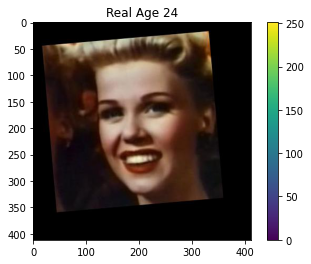

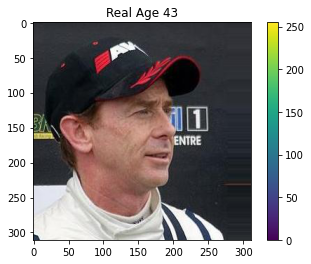

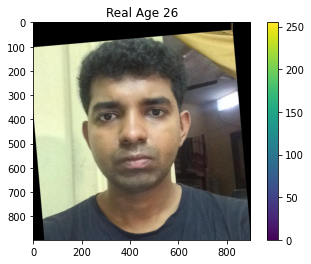

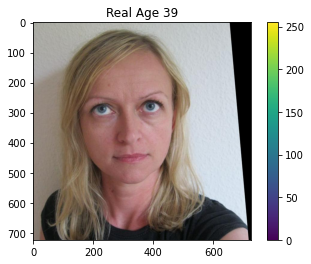

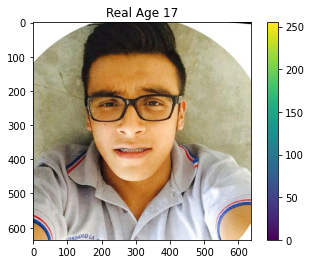

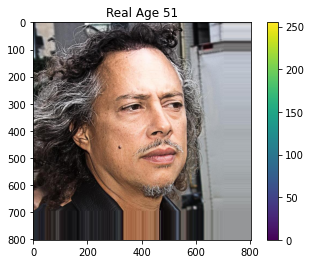

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

for i,k in zip(labels.file_name[:15],labels.real_age[:12]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


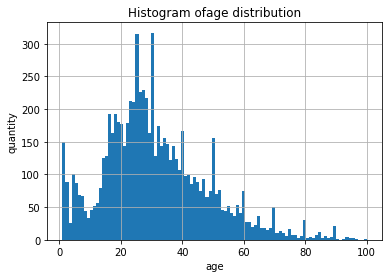

In [4]:
labels.shape

labels.hist(bins = 100)

plt.title('Histogram ofage distribution')
plt.xlabel('age')
plt.ylabel('quantity')

labels

Text(0.5, 1.0, 'Boxplot of age distribution')

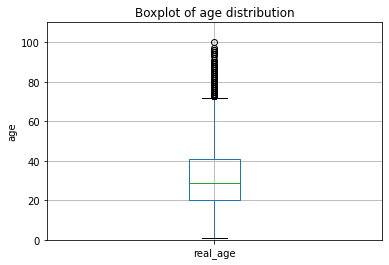

In [8]:
labels.boxplot()
plt.ylim(0, 110)
plt.ylabel('age')
plt.title('Boxplot of age distribution')

Text(0.5, 1.0, 'Boxplot of age distribution')

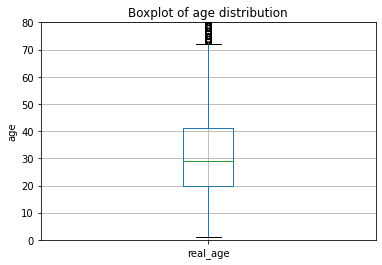

In [10]:
labels.boxplot()
plt.ylim(0, 80)
plt.ylabel('age')
plt.title('Boxplot of age distribution')


    
Исходя из полученных данных, можно сделать вывод,что кол-ва данных для последующего обучения хватат,по  графикам моджно сделать вывод,что больше всего фотографий с возрастом ~ 20 - 35 лет,медианное значение находится на уровне 29 лет, хвосты же начинают тянуться от  ~  72 и заканчиваются на возрасте 100 (есть долгожители, и это чень круто хорошо,как для обучения так и для человечесвта в целом 😁)
Рассмотрев некотрые фото,я увидел, что все они в разном качестве,есть фото с доп фичами,например с флипами и смещнием,что хорошо скажется на обучение модели, даже без дополнительных "улучшалок".
Аугментацию,как мне кажется, стоит использовать,для увеличения выборки и улучшения показателей.


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [4]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd



def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

# <Epoch 1/10
178/178 - 64s - loss: 196.0765 - mae: 10.3053 - val_loss: 546.3193 - val_mae: 18.3155
Epoch 2/10
178/178 - 50s - loss: 90.4878 - mae: 7.2067 - val_loss: 669.7983 - val_mae: 20.8952
Epoch 3/10
178/178 - 48s - loss: 70.4075 - mae: 6.3395 - val_loss: 291.2863 - val_mae: 12.8226
Epoch 4/10
178/178 - 48s - loss: 50.7634 - mae: 5.4033 - val_loss: 147.9319 - val_mae: 9.1307
Epoch 5/10
178/178 - 57s - loss: 39.3176 - mae: 4.7694 - val_loss: 86.1309 - val_mae: 6.8961
Epoch 6/10
178/178 - 60s - loss: 34.7446 - mae: 4.5291 - val_loss: 130.5111 - val_mae: 8.9806
Epoch 7/10
178/178 - 61s - loss: 27.2634 - mae: 4.0290 - val_loss: 76.8531 - val_mae: 6.5797
Epoch 8/10
178/178 - 62s - loss: 24.0127 - mae: 3.7546 - val_loss: 72.4890 - val_mae: 6.4504
Epoch 9/10
178/178 - 59s - loss: 19.6485 - mae: 3.4067 - val_loss: 82.2127 - val_mae: 6.9919
Epoch 10/10
178/178 - 62s - loss: 17.0289 - mae: 3.1224 - val_loss: 65.1238 - val_mae: 5.9504>
```

## Анализ обученной модели

    В данном проекте рассматривался датасет из фотографий в количестве 7591 штук,с нормальным распределением и большим количеством людей с возрастом от 20 до 30 лет.Для улучшения метрики был подобран  оптимальный Adam,использованы флипы и изменения яркости для улуучшения обучаеемости.ПОставленную задачу с метрикой ниже 8 - выполниил,хотя можно было бы сделать алгоритм работающий быстрее,но про время ничего не было сказано.   

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы